# Homework 4

Name: Ali Furkan Kalay

ID: 45625365

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.stats import norm,invgamma

## Question 1

In [2]:
def weight_root(func=np.polynomial.legendre.leggauss, up = 11):
    x_GL = []
    w_GL = []
    for i in range(2,up):
        x,w = func(i)
        x_GL += [x]
        w_GL += [w]
    return x_GL, w_GL

In [3]:
f1 = lambda x: x ** 0.25
a1,b1 = 0.,1.
f1_cv = lambda x: f1(a1+(b1-a1)*(x+1.)/2)

In [4]:
f2 = lambda x: x ** (-2)
a2,b2 = 1.,10.
f2_cv = lambda x: f2(a2+(b2-a2)*(x+1.)/2)

In [5]:
f3 = lambda x: np.e ** x
a3,b3 = 0.,1.
f3_cv = lambda x: f3(a3+(b3-a3)*(x+1.)/2)

In [6]:
f4 = lambda x: np.max([0, x+0.05])
a4,b4 = -1., 1.
f4_cv = lambda x: f4(a4+(b4-a4)*(x+1.)/2)

In [7]:
def gauss_legendre(func, interval_lenght):
    nodes_vec = [4,7,10,13]
    x_GL, w_GL = weight_root(up=16)
    I1_GL = np.zeros(len(nodes_vec))
    for i,n in enumerate(nodes_vec):
        roots = np.array(x_GL[n-2])
        I1_GL[i] = (interval_lenght)/2*(np.array([func(i) for i in roots])@w_GL[n-2])
        # I replaced `func(roots)` with `np.array([func(i) for i in roots])`
        # Because 4th function causes error
        print((n, round(I1_GL[i], 4)))

In [8]:
gauss_legendre(f1_cv, b1-a1)

(4, 0.8023)
(7, 0.8006)
(10, 0.8003)
(13, 0.8001)


In [9]:
gauss_legendre(f2_cv, b2-a2)

(4, 0.8563)
(7, 0.8985)
(10, 0.9)
(13, 0.9)


In [10]:
gauss_legendre(f3_cv, b3-a3)

(4, 1.7183)
(7, 1.7183)
(10, 1.7183)
(13, 1.7183)


In [11]:
gauss_legendre(f4_cv, b4-a4)

(4, 0.5713)
(7, 0.5457)
(10, 0.5538)
(13, 0.5513)


## Question 2

I am using the formulation given here: http://www.wouterdenhaan.com/numerical/integrationslides.pdf

The weighting function for the Gauss-Hermite quadrature is $e^{-x^2}$ on $(-\infty,\infty)$. 

$$E[f(x)] = \int_{-\infty}^\infty f(x)e^{-x^2}dx \approx \sum_{i=1}^\infty \omega_i f(x_i).$$

We cannot directly apply Gauss-Hermite to Normal distribution, mainly because we have different weighting functions, $e^{-\frac{(x-\mu)^2}{2\sigma^2}}$ instead of $e^{-x^2}$:

$$E[h(x)] = \int_{-\infty}^\infty \frac{1}{\sqrt{2\pi\sigma^2}} h(x) e^{-\frac{(x-\mu)^2}{2\sigma^2}}dx. $$

where we will replaced $h(x)$ with $x, (x-u)^2, (\frac{x-u}{\sigma }) ^3,$ and $ (\frac{x-u}{\sigma }) ^4$ respectively for mean, variance, skewness and kurtosis integration. In order to apply Gauss-Hermite quadrature we have to manipulate this integration that has the same weighting function. So we replace $x$ with $x' = \frac{(x-\mu)}{\sqrt{2} \sigma}$ and integration becomes:

\begin{align*}
E[h(x)] &= \int_{-\infty}^\infty \frac{1}{\sqrt{\pi }} h(2\sigma x' + \mu) e^{-x^{'2}}dx'  \\
&\approx \sum _{i=1} ^n \frac{1}{\sqrt{\pi }} w_i h(2\sigma x_i + \mu)
\end{align*}

where $w_i$ is Gauss-Hermite sample weights and $x_i$ Gauss-Hermite sample points.

Suppose we have the mean and standard deviation:

In [12]:
mmu = 1.0
ssig = 2.0 

So integration of:

- Mean: 1
- Variance: 4
- Skewness: 0
- Kurtosis: 3

Our parameterization only changes Mean and Variance the others are standard values for any mean and variance. 

Let's implement approximation formula above:

In [13]:
def gauss_hermite(func, muu = mmu, ssig = ssig):
    x_GL, w_GL = weight_root(np.polynomial.hermite.hermgauss, up=16)
    nodes_vec = [3, 5, 10, 15]
    I1_GL = np.zeros(len(nodes_vec))
    for i,n in enumerate(nodes_vec):
        roots = np.array(x_GL[n-2])
        I1_GL[i] = func(np.sqrt(2)*ssig* roots + mmu)@w_GL[n-2] / np.sqrt(np.pi)
        print((n, round(I1_GL[i], 10)))

$h(x)$ functions:

In [14]:
mean = lambda x: x
variance = lambda x: (x-mmu)**2
skewness = lambda x: ((x-mmu)/ssig)**3
kurtosis = lambda x: ((x-mmu)/ssig)**4

In [15]:
gauss_hermite(mean)

(3, 1.0)
(5, 1.0)
(10, 1.0)
(15, 1.0)


In [16]:
gauss_hermite(variance)

(3, 4.0)
(5, 4.0)
(10, 4.0)
(15, 4.0)


In [17]:
gauss_hermite(skewness)

(3, 0.0)
(5, 0.0)
(10, -0.0)
(15, 0.0)


In [18]:
gauss_hermite(kurtosis)

(3, 3.0)
(5, 3.0)
(10, 3.0)
(15, 3.0)


## Question 3

Function to be integrated:

In [19]:
f = np.vectorize(lambda x: x ** (0.25))

1000 Manto Carlo simulation function:

In [20]:
def monte_carlo_integration(func, N, K=1000, seed = 123):
    np.random.seed(seed)
    integrations = []
    for i in range(K):
        # One simulation..Random N sampling from Uniform distribution U[0,1]
        integrations.append(func(np.random.rand(N)).mean()) 
    return np.array(integrations)

In [21]:
simulations = pd.DataFrame()
simulations['N = 10'] = monte_carlo_integration(f, 10)
simulations['N = 100'] = monte_carlo_integration(f, 100)
simulations['N = 1000'] = monte_carlo_integration(f, 1000)

As seen in the plot below, when we set sample size small, variance of integration values is high. 

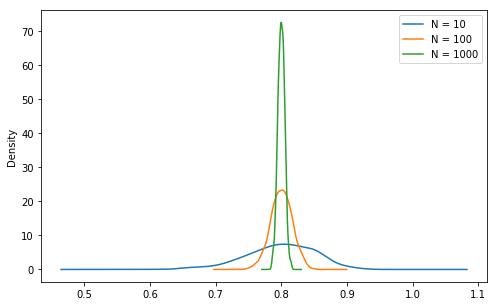

In [22]:
simulations.plot(kind='density', figsize = (8,5))
plt.show()

The standard deviations are 0.052, 0.016, and 0.005 respectively for sample size 10, 100, 1000. Obviously range also decreases with sample size. 

In [23]:
simulations.describe()

,N = 10,N = 100,N = 1000
count,1000.000000,1000.000000,1000.000000
mean,0.798951,0.800383,0.800080
std,0.051897,0.016321,0.005135
min,0.619236,0.747982,0.785452
25%,0.765992,0.789605,0.796569
50%,0.801828,0.800733,0.800101
75%,0.837447,0.811632,0.803601
max,0.928351,0.849232,0.815575


## Question 4

I modify the codes used in the lectures. We know the mean of the distribution but do not know the sigma. 

In [24]:
np.random.seed(123)

# Suppose true sigma is:
sigma_true = 4

# Our prior belief of inverse gamma distribution parameters:
# inverted gamma with degrees of freedom `alpha` and scale `beta`
alpha, beta = 7.,1. 

# Know mean value:
mu_known = 5.0
data = sigma_true * np.random.randn(20) + mu_known # data

# Propose width:
propose_sigma_mc = 2

# initial guess
sigma_current = 6. 

samples = 15000

posterior = [sigma_current]
for i in range(samples):
    # Since sigma > 0, I will take absolute value of sigma proposal,
    sigma_proposal = np.absolute(norm(loc=sigma_current, scale=propose_sigma_mc).rvs()) 
    
    # We know the Mean and we calculate the current and proposal Sigmas:
    likelihood_current = norm(mu_known, sigma_current).pdf(data).prod() 
    likelihood_proposal = norm(mu_known, sigma_proposal).pdf(data).prod()
    
    # Compute prior probability of current and proposed mu 
    prior_current = invgamma(alpha, beta).pdf(sigma_current)
    prior_proposal = invgamma(alpha, beta).pdf(sigma_proposal)
    
    # Numerator of Bayes formula
    p_current = likelihood_current * prior_current
    p_proposal = likelihood_proposal * prior_proposal

    p_accept = p_proposal / p_current

    accept = np.random.rand() < p_accept

    if accept:
        sigma_current = sigma_proposal

    posterior.append(sigma_current) 

I tried to keep sigma_proposal to be positive with given scale and width parameters. I think with current adjustment using absolute value does not disturb the sigma proposal distribution. It can be a problem with different parameterization. 

- The inverse Gamma distribution: $IG(7,1)$
- True mean: 5 (Known)
- True Sigma: 4 (Unknown)
- Proposed width SD: 2

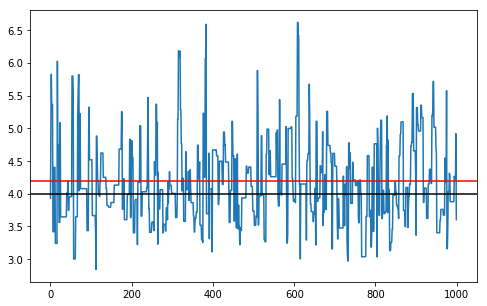

In [25]:
plt.figure(figsize=(8,5))
plt.plot(posterior[-1000:], label='Trace')
plt.axhline(y=np.mean(posterior), color = 'red') # Posterior sigma mean
plt.axhline(y=sigma_true, color = 'black') # True Sigma
plt.show()

The proposed sigma mean is greater than true value of sigma. 

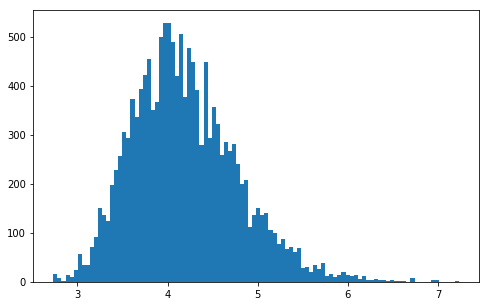

In [26]:
plt.figure(figsize=(8,5))
plt.hist(posterior[500:],100)
plt.show()

The distribution of sigma is slightly right-skewed. 